In [1]:
# 필요한 라이브러리를 설치합니다.
# PyTorch 기반 SOTA 이미지 모델 라이브러리 ; resnet34 불러오기 위함
!pip install timm

In [2]:
import os
import time

import timm # 모델
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image # 이미지 입출력
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# EDA

In [3]:
from pathlib import Path
import pandas as pd

CANDIDATES = [Path("."), Path(".."), Path("../.."), Path("../../..")]
ROOT = None
for base in CANDIDATES:
    if (base / "train.csv").exists() and (base / "train").exists():
        ROOT = base.resolve()
        break
if ROOT is None:
    raise FileNotFoundError("train.csv 및 train 폴더를 찾지 못했습니다.")

TRAIN_DIR = ROOT / "train"
print("ROOT:", ROOT)
print("TRAIN_DIR exists:", TRAIN_DIR.exists())

train_df = pd.read_csv(ROOT / "train.csv")
train_df.head()

ROOT: /root/cv_data
TRAIN_DIR exists: True


,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16


target
0     100
1      46
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
11    100
12    100
13     74
14     50
15    100
16    100
Name: count, dtype: int64

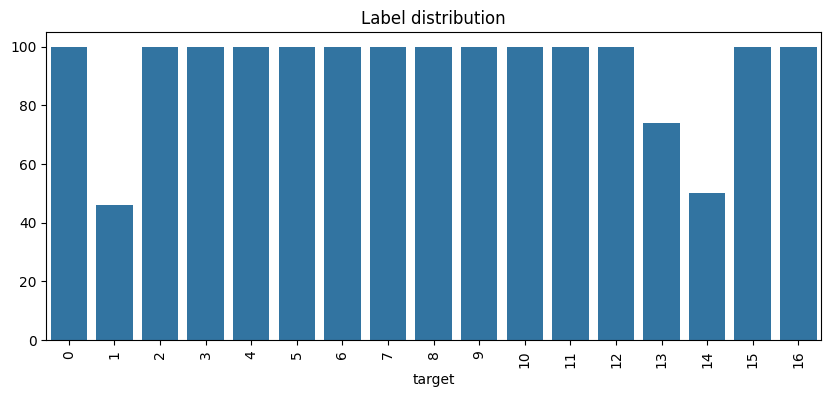

Imbalance ratio (max/min): 2.17


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = train_df["target"].value_counts().sort_index()
display(counts)

plt.figure(figsize=(10,4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Label distribution")
plt.xticks(rotation=90)
plt.show()

imbalance_ratio = counts.max() / counts.min()
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")

In [5]:
dup_id = train_df.duplicated(subset=["ID"]).sum()
dup_pair = train_df.duplicated(subset=["ID","target"]).sum()
id_conflict = (train_df.groupby("ID")["target"].nunique()>1).sum()

print("중복 ID:", dup_id)
print("중복 (ID,target):", dup_pair)
print("서로 다른 라벨을 가진 ID(라벨 충돌):", id_conflict)

중복 ID: 0
중복 (ID,target): 0
서로 다른 라벨을 가진 ID(라벨 충돌): 0


In [6]:
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import numpy as np
from collections import Counter

missing, unreadable, flat_images, modes = [], [], [], []

for fname in tqdm(train_df["ID"]):
    p = TRAIN_DIR / fname
    if not p.exists():
        missing.append(fname)
        continue
    try:
        im = Image.open(p)
        modes.append(im.mode)
        arr = np.array(im)
        if arr.size == 0 or arr.std() == 0:
            flat_images.append(fname)
    except (UnidentifiedImageError, OSError):
        unreadable.append(fname)

print("없는 파일 수:", len(missing))
print("읽기 불가 파일 수:", len(unreadable))
print("단색/이상치 의심 수:", len(flat_images))
print("Image modes:", Counter(modes))

100%|██████████| 1570/1570 [00:06<00:00, 256.31it/s]

없는 파일 수: 0
읽기 불가 파일 수: 0
단색/이상치 의심 수: 0
Image modes: Counter({'RGB': 1570})


Checked images: 1570


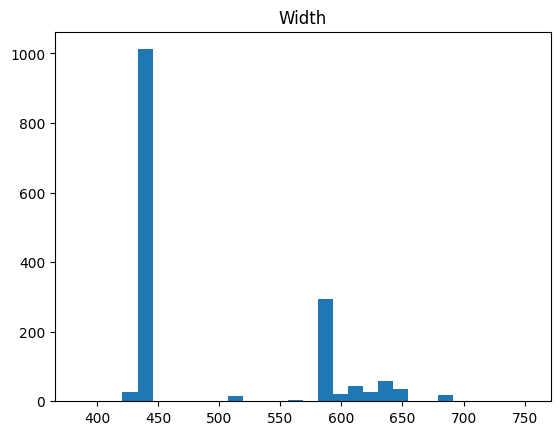

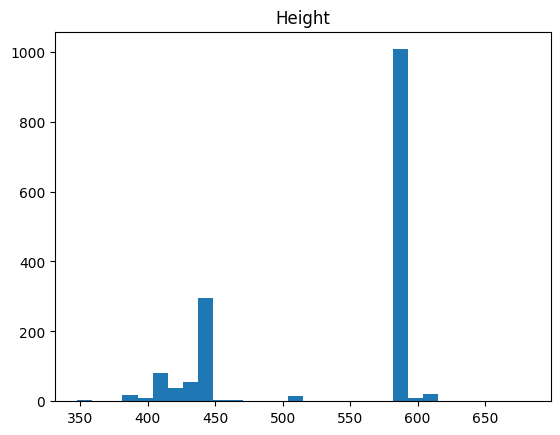

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

widths, heights = [], []
checked = 0
for fname in train_df["ID"]:
    p = TRAIN_DIR / fname
    if not p.exists():
        continue
    try:
        im = Image.open(p)
        w, h = im.size
        widths.append(w); heights.append(h)
        checked += 1
    except:
        pass

print("Checked images:", checked)
plt.figure(); plt.hist(widths, bins=30); plt.title("Width"); plt.show()
plt.figure(); plt.hist(heights, bins=30); plt.title("Height"); plt.show()

In [8]:
# 이미지 모드/채널 통계 + 클래스별 분포

from PIL import Image, UnidentifiedImageError
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm

mode_counts = Counter()
mode_by_cls = defaultdict(Counter)

sizes = []
sizes_by_cls = defaultdict(list)

brightness = []              # 전체 밝기 (0~255 평균)
contrast = []                # 픽셀 표준편차
brightness_by_cls = defaultdict(list)
contrast_by_cls = defaultdict(list)

checked = 0
for fname, y in tqdm(zip(train_df["ID"], train_df["target"]), total=len(train_df)):
    p = (TRAIN_DIR / fname)
    if not p.exists():
        continue
    try:
        im = Image.open(p).convert("RGB")  # 입력 통일(RGB)
        mode_counts["RGB"] += 1
        mode_by_cls[y]["RGB"] += 1

        w, h = im.size
        sizes.append((w, h))
        sizes_by_cls[y].append((w, h))

        arr = np.asarray(im)  # (H,W,3) uint8
        b = arr.mean()        # 밝기 proxy
        c = arr.std()         # 대비 proxy
        brightness.append(b); contrast.append(c)
        brightness_by_cls[y].append(b); contrast_by_cls[y].append(c)

        checked += 1
    except (UnidentifiedImageError, OSError):
        pass

print("Checked:", checked)
print("Image modes:", mode_counts)

# 크기 통계
sizes_df = pd.DataFrame(sizes, columns=["width", "height"])
display(sizes_df.describe())

# 클래스별 크기 요약
rows = []
for cls, wh in sizes_by_cls.items():
    if not wh: continue
    w = np.array([x for x,_ in wh]); h = np.array([y for _,y in wh])
    rows.append([cls, w.mean(), h.mean(), np.median(w), np.median(h)])
sizes_by_cls_df = pd.DataFrame(rows, columns=["class","mean_w","mean_h","median_w","median_h"]).sort_values("class")
display(sizes_by_cls_df)


100%|██████████| 1570/1570 [00:06<00:00, 233.90it/s]

Checked: 1570
Image modes: Counter({'RGB': 1570})


,width,height
count,1570.000000,1570.000000
mean,497.613376,538.169427
std,79.370316,76.074772
min,384.000000,348.000000
25%,443.000000,443.000000
50%,443.000000,591.000000
75%,591.000000,591.000000
max,753.000000,682.000000


,class,mean_w,mean_h,median_w,median_h
14,0,482.96,551.030000,443.0,591.0
15,1,443.00,591.000000,443.0,591.0
10,2,588.04,445.960000,591.0,443.0
13,3,443.00,591.000000,443.0,591.0
2,4,443.00,591.000000,443.0,591.0
3,5,611.81,431.690000,628.0,416.5
16,6,499.21,535.380000,443.0,591.0
8,7,443.00,591.000000,443.0,591.0
11,8,613.43,430.960000,633.0,413.0
6,9,608.98,432.560000,603.5,433.5


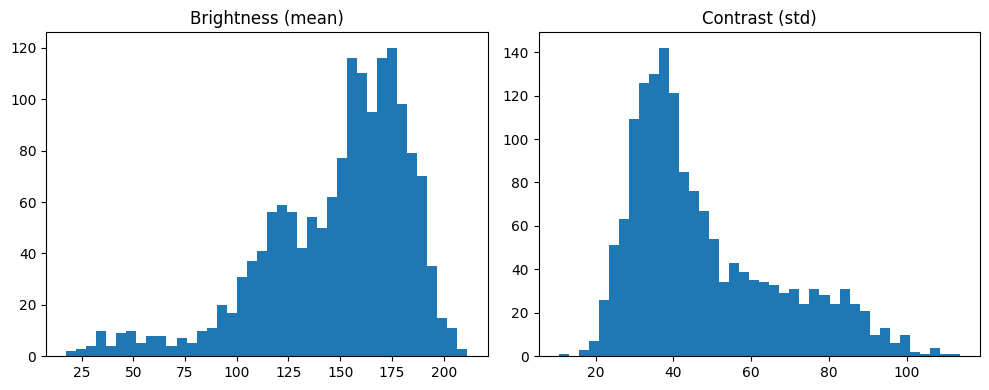

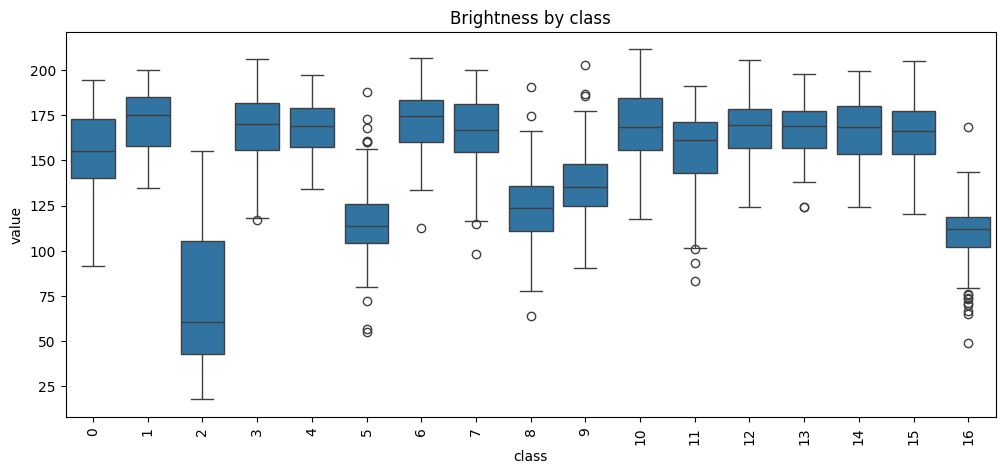

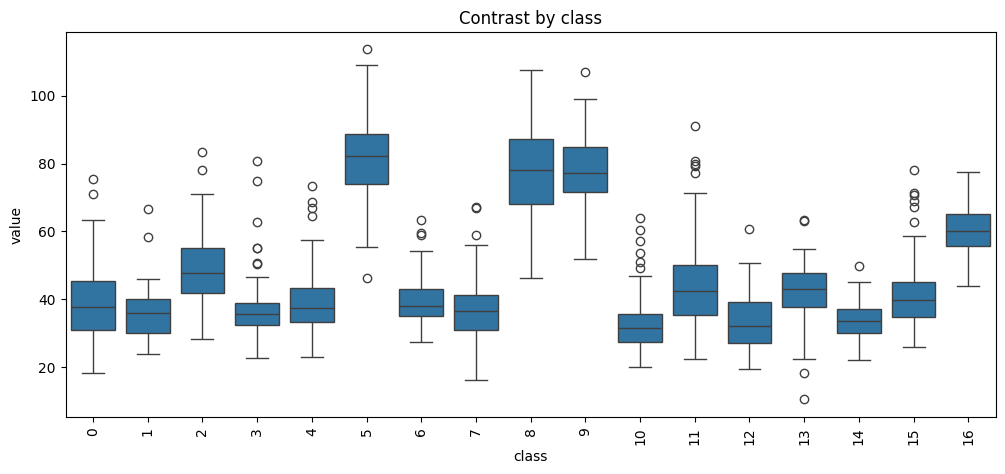

In [9]:
# 밝기/대비 분포 시각화

import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.hist(brightness, bins=40); plt.title("Brightness (mean)")
plt.subplot(1,2,2); plt.hist(contrast,   bins=40); plt.title("Contrast (std)")
plt.tight_layout(); plt.show()

# 클래스별 박스플롯
tmp = []
for cls, vals in brightness_by_cls.items():
    for v in vals: tmp.append(("brightness", cls, v))
for cls, vals in contrast_by_cls.items():
    for v in vals: tmp.append(("contrast", cls, v))
eda_bc = pd.DataFrame(tmp, columns=["metric","class","value"])

plt.figure(figsize=(12,5))
sns.boxplot(data=eda_bc[eda_bc["metric"]=="brightness"], x="class", y="value")
plt.title("Brightness by class"); plt.xticks(rotation=90); plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(data=eda_bc[eda_bc["metric"]=="contrast"], x="class", y="value")
plt.title("Contrast by class"); plt.xticks(rotation=90); plt.show()


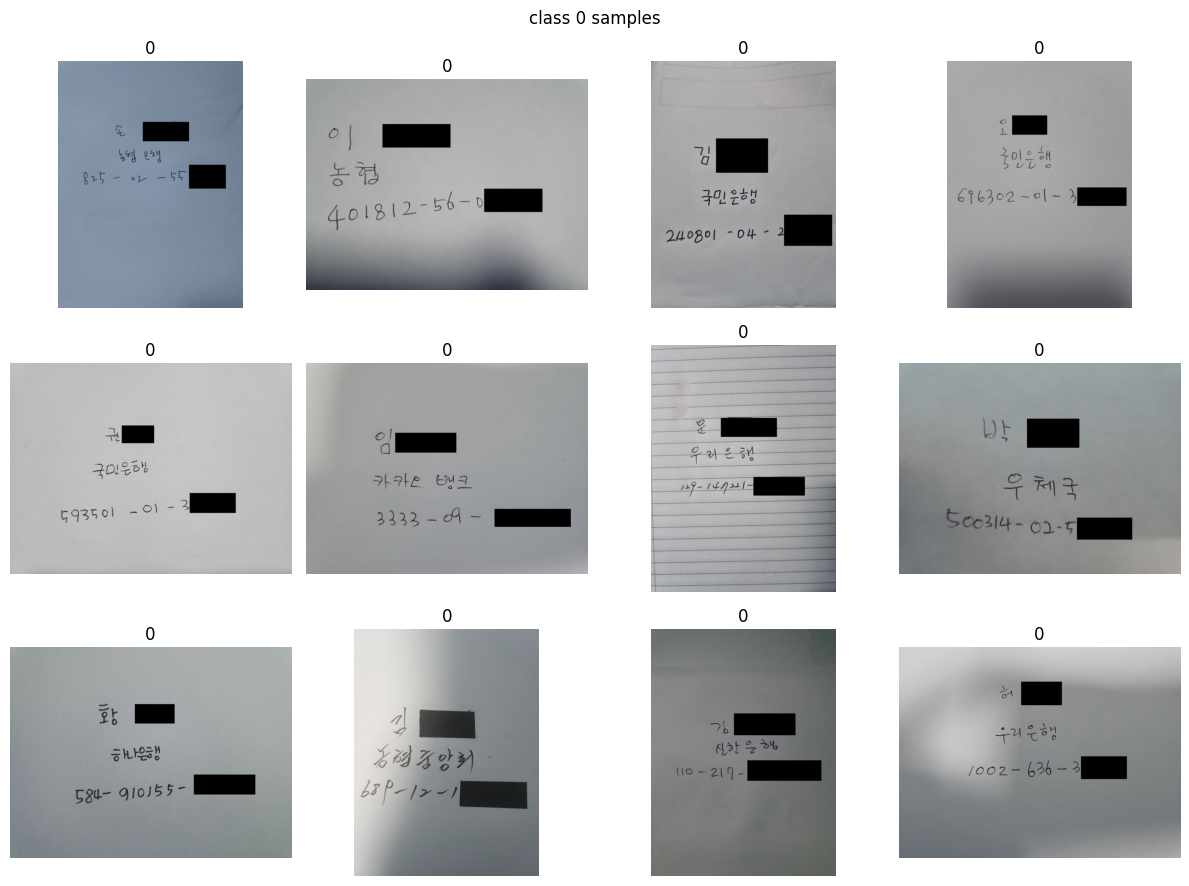

In [10]:
# 랜덤 샘플 그리드로 클래스별 시각화

import random
import math

def show_class_grid(cls, n=16):
    ids = train_df[train_df["target"]==cls]["ID"].tolist()
    sample = random.sample(ids, min(n, len(ids)))
    cols = 4; rows = math.ceil(len(sample)/cols)
    plt.figure(figsize=(cols*3, rows*3))
    for i,fname in enumerate(sample):
        im = Image.open(TRAIN_DIR / fname).convert("RGB")
        plt.subplot(rows, cols, i+1); plt.imshow(im); plt.axis("off"); plt.title(str(cls))
    plt.suptitle(f"class {cls} samples"); plt.tight_layout(); plt.show()

show_class_grid(cls=0, n=12)  # 필요 클래스 몇 개 반복 호출


100%|██████████| 1570/1570 [00:06<00:00, 261.56it/s]


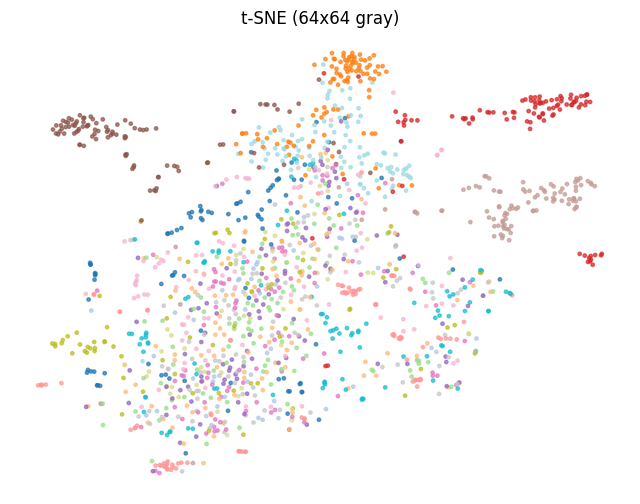

In [11]:
# 가벼운 임베딩으로 t-SNE 시각화

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

N = min(2000, len(train_df))           # 샘플 수 제한
sample_df = train_df.sample(N, random_state=42)

X = []
y = []
for fname, label in tqdm(zip(sample_df["ID"], sample_df["target"]), total=len(sample_df)):
    p = TRAIN_DIR / fname
    try:
        im = Image.open(p).convert("L").resize((64,64))
        X.append(np.asarray(im).reshape(-1))  # 4096차원
        y.append(label)
    except:
        pass

X = np.array(X, dtype=np.float32)
y = np.array(y)
X = StandardScaler().fit_transform(X)

tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
Z = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=y, s=6, alpha=0.7, cmap="tab20")
plt.title("t-SNE (64x64 gray)"); plt.axis("off"); plt.show()


In [12]:
# 데이터셋 평균/표준편차 계산

import torch
from torchvision import transforms

# 빠르게 계산하기 위해 일부 샘플만 사용
K = min(4000, len(train_df))
sample = train_df.sample(K, random_state=0)["ID"].tolist()

to_tensor = transforms.ToTensor()  # [0,1], CxHxW
sum_, sumsq_, count = torch.zeros(3), torch.zeros(3), 0

for fname in tqdm(sample):
    p = TRAIN_DIR / fname
    try:
        img = Image.open(p).convert("RGB")
        t = to_tensor(img)  # (3,H,W)
        c, h, w = t.shape
        sum_   += t.reshape(c, -1).sum(dim=1)
        sumsq_ += (t.reshape(c, -1)**2).sum(dim=1)
        count  += h*w
    except:
        pass

mean = (sum_/count).tolist()
std  = torch.sqrt(sumsq_/count - (sum_/count)**2).tolist()
print("Dataset mean:", mean)
print("Dataset std :", std)


100%|██████████| 1570/1570 [00:23<00:00, 66.02it/s]

Dataset mean: [0.5743427872657776, 0.5833091735839844, 0.5881960391998291]
Dataset std : [0.24590566754341125, 0.24587500095367432, 0.24521729350090027]
